# Model Version 3

Objective : Reduce Overfitting and Apply RandomRotation to improve accuracy

## Importing Libraries



In [8]:
import torch
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm
from model import Model_3 # model.py
from utils import *
from torch.utils.data import DataLoader, Dataset



## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(fill=(0,),degrees=(-5,5)),
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [3]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

100%|██████████| 9912422/9912422 [00:00<00:00, 468474554.01it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113529235.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93919976.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27176217.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## CONSTANTS

In [4]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 15

## Data Loading

In [5]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

kwargs = {'shuffle' : True,'batch_size' : BATCHSIZE,'num_workers': 4, 'pin_memory': True} if cuda else {'shuffle' : True,'batch_size' : BATCHSIZE_2}

train_loader = torch.utils.data.DataLoader(train, **kwargs) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **kwargs) # creating test dataloader

CUDA Available True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Summary


In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = Model_3().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              81
       BatchNorm2d-2            [-1, 9, 26, 26]              18
         Dropout2d-3            [-1, 9, 26, 26]               0
            Conv2d-4           [-1, 18, 24, 24]           1,458
       BatchNorm2d-5           [-1, 18, 24, 24]              36
         Dropout2d-6           [-1, 18, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]             216
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 18, 10, 10]           1,944
      BatchNorm2d-10           [-1, 18, 10, 10]              36
        Dropout2d-11           [-1, 18, 10, 10]               0
           Conv2d-12             [-1, 18, 8, 8]           2,916
      BatchNorm2d-13             [-1, 18, 8, 8]              36
        Dropout2d-14             [-1, 1

## Model training

In [9]:
model =  Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)

Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Train: Loss=0.1731 Batch_id=468 Accuracy=84.28: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]


Test set: Average loss: 0.0980, Accuracy: 9749/10000 (97.49%)

Epoch 2


Train: Loss=0.1307 Batch_id=468 Accuracy=95.72: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]


Test set: Average loss: 0.0552, Accuracy: 9850/10000 (98.50%)

Epoch 3


Train: Loss=0.0317 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]


Test set: Average loss: 0.0445, Accuracy: 9864/10000 (98.64%)

Epoch 4


Train: Loss=0.1146 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]


Test set: Average loss: 0.0436, Accuracy: 9865/10000 (98.65%)

Epoch 5


Train: Loss=0.0421 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]


Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

Epoch 6


Train: Loss=0.0360 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]


Test set: Average loss: 0.0319, Accuracy: 9894/10000 (98.94%)

Epoch 7


Train: Loss=0.0220 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Test set: Average loss: 0.0319, Accuracy: 9896/10000 (98.96%)

Epoch 8


Train: Loss=0.0450 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

Epoch 9


Train: Loss=0.0737 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Test set: Average loss: 0.0276, Accuracy: 9915/10000 (99.15%)

Epoch 10


Train: Loss=0.0437 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Test set: Average loss: 0.0257, Accuracy: 9917/10000 (99.17%)

Epoch 11


Train: Loss=0.0421 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

Epoch 12


Train: Loss=0.0239 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

Epoch 13


Train: Loss=0.0608 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]


Test set: Average loss: 0.0230, Accuracy: 9919/10000 (99.19%)

Epoch 14


Train: Loss=0.0919 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

Epoch 15


Train: Loss=0.0921 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

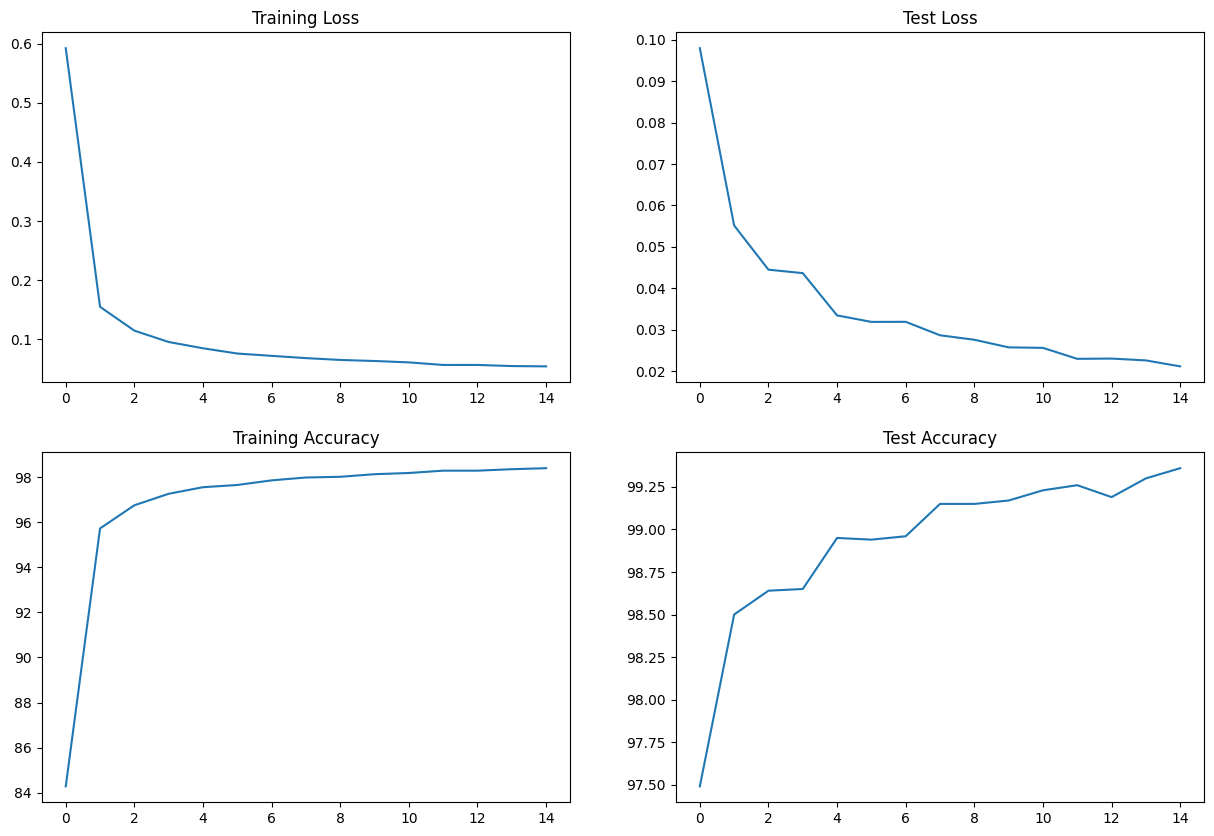

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [11]:
print(f'Training Accuracy : {max(train_acc)}')
print(f'Test Accuracy:{max(test_acc)}')

Training Accuracy : 98.395
Test Accuracy:99.36


## Results :

* Model : Model_3
* Targets: Handle Overfitting and Improve Accuracy
* Results:
    - Training Accuracy : 98.39
    - Test Accuracy : 99.36
    - Parameters : 9873

### Analysis:
* Added Dropout layer to Handle Overfitting
* Added Transformation (RandomRotation) augmentation
* It is evident from Train and Test accuracy that Model is generalizing well not Overfitting
* Observed that after 8th Epoch Model may stuck at local Minima. Probably LR schedular to be used to get improve learning.